# Ensemble Learning Project

This project implements **two fundamental ensemble learning algorithms from scratch**: **Random Forest** (bagging) for regression and **AdaBoost** (boosting) for classification. The project demonstrates how combining multiple weak learners can create powerful predictive models that outperform individual base estimators.

## Problem Statement

Ensemble learning combines multiple models to improve predictive performance. Two primary approaches are:

1. **Bagging (Bootstrap Aggregation)**: Trains models independently on different bootstrap samples and averages their predictions
2. **Boosting**: Trains models sequentially, where each new model focuses on correcting the mistakes of previous models

### What is Ensemble Learning?

**Ensemble Learning** is a machine learning paradigm that combines multiple base models (weak learners) to create a more robust and accurate predictive model. The key principle is that a diverse collection of models often performs better than any single model.

**Two Main Paradigms**:

1. **Bagging (Bootstrap Aggregation)**:
   - Trains multiple models independently on different bootstrap samples
   - Reduces variance by averaging predictions
   - Models can be trained in parallel
   - Example: Random Forest

2. **Boosting**:
   - Trains models sequentially, each focusing on previous mistakes
   - Reduces both bias and variance
   - Models must be trained sequentially
   - Example: AdaBoost, Gradient Boosting

**Key Advantages**:
- Improved generalization through model diversity
- Robustness to overfitting
- Better handling of complex patterns
- Often achieves state-of-the-art performance

## Project Overview

This project provides **complete from-scratch implementations** of two ensemble learning algorithms, demonstrating both bagging and boosting approaches:

1. **Random Forest Regressor**: Custom bagging implementation using bootstrap aggregation
2. **AdaBoost Classifier**: Custom boosting implementation using weighted bootstrap sampling
3. **Hyperparameter Optimization**: Systematic tuning using grid search and cross-validation
4. **Model Evaluation**: Comprehensive analysis including out-of-bag error estimation and learning curves
5. **Real-World Applications**: Evaluation on bike sharing dataset (regression) and synthetic classification datasets

### 1. Random Forest Implementation

**Random Forest** is a bagging ensemble method that combines multiple decision trees:

1. **Bootstrap Sampling**: Each tree is trained on a random bootstrap sample of the training data
2. **Feature Subsampling**: At each split, only a random subset of features is considered
3. **Averaging**: Final prediction is the average of all tree predictions
4. **Out-of-Bag (OOB) Error**: Each tree can be evaluated on samples it didn't see during training

**Mathematical Foundation**:
- For regression: $\hat{y} = \frac{1}{B}\sum_{b=1}^{B} T_b(x)$ where $B$ is the number of trees
- Bootstrap sampling creates diversity among trees
- Averaging reduces variance without increasing bias
- OOB error provides efficient model evaluation without a separate validation set

**Key Features**:
- Handles continuous input and output data
- Reduces overfitting through ensemble averaging
- Provides feature importance through tree splits
- Computationally efficient (trees can be trained in parallel)

### 2. AdaBoost Implementation

**AdaBoost** (Adaptive Boosting) is a boosting ensemble method that combines weak learners sequentially:

1. **Weighted Bootstrap Sampling**: Each iteration samples data based on current sample weights
2. **Weighted Error Calculation**: Computes error rate weighted by sample importance
3. **Prediction Flipping**: If a weak learner performs worse than random (error > 0.5), its predictions are flipped
4. **Confidence Weighting**: Each learner is assigned a confidence weight based on its error rate
5. **Weighted Voting**: Final prediction is a weighted sign vote of all learners

**Mathematical Foundation**:
- Sample weights: $w_i^{(t+1)} = w_i^{(t)} \exp(-\alpha_t y_i h_t(x_i))$ where $\alpha_t$ is the confidence
- Confidence: $\alpha_t = \frac{1}{2}\log(\frac{1-\epsilon_t}{\epsilon_t})$ where $\epsilon_t$ is the weighted error
- Final prediction: $H(x) = \text{sign}(\sum_{t=1}^{T} \alpha_t h_t(x))$

**Key Features**:
- Adaptively focuses on difficult examples
- Handles binary classification with {-1, +1} labels
- Robust to weak learners that perform worse than random
- Visualizes learning dynamics through weight evolution

## Part 1: Random Forest Implementation

A Random Forest Regressor is implemented from scratch that handles **continuous input and output** data.

In [3]:
import io
import requests
from typing import Tuple, List
import zipfile
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:

def read_csv_from_zip(url: str, specific_file: str) -> pd.DataFrame:
   """
   Reads a specific CSV file from a zip archive located at a given URL.

   Args:
       url (str): The URL of the zip file
       specific_file (str): The name of the specific CSV file inside the zip

   Returns:
       pd.DataFrame: DataFrame containing the data from the CSV file

   Raises:
       requests.exceptions.RequestException: If there is an error downloading the file
       FileNotFoundError: If the specified file is not found in the zip archive
   """
   # Download the zip file
   response = requests.get(url)
   response.raise_for_status()  # Check if the request was successful

   # Open the zip file in memory
   with zipfile.ZipFile(io.BytesIO(response.content)) as z:
       # Check if the specific file exists in the zip
       if specific_file not in z.namelist():
           raise FileNotFoundError(
               f"{specific_file} not found in the zip archive. "
               f"Available files: {z.namelist()}"
           )

       # Open the specific file and read it with pandas
       with z.open(specific_file) as f:
           return pd.read_csv(f)

def load_bike_sharing_data(dataset: str = 'day') -> Tuple[np.ndarray, np.ndarray, List[str]]:
   """
   Loads the Bike Sharing dataset and preprocesses it for regression.

   Args:
       dataset (str): Either 'day' or 'hour' to specify which data granularity to load

   Returns:
       Tuple containing:
           np.ndarray: Feature matrix X
           np.ndarray: Target vector y (total rentals)
           List[str]: List of feature names

   Notes:
       - Sets 'instant' as index
       - Removes date, year, and separated rental counts
       - Target variable 'cnt' represents total rentals
   """
   # Load data from UCI ML Repository
   url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
   specific_file = f"{dataset}.csv"

   # Read and preprocess the data
   df = read_csv_from_zip(url, specific_file)
   df = df.set_index('instant')  # Set ID column as index

   # Extract target variable (total rentals)
   y = df['cnt'].values

   # Remove unnecessary columns:
   # - dteday: redundant date information
   # - casual, registered: total count is used only
   # - cnt: this is our target variable
   df = df.drop(['dteday', 'casual', 'registered', 'cnt'], axis=1)

   # Convert features to numpy array and get feature names
   X = df.values
   attribute_names = list(df.columns)

   return X, y, attribute_names

# Load the daily bike sharing data
X, y, attribute_names = load_bike_sharing_data("day")

In [5]:
from typing import Union, Optional
import numpy.typing as npt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
class TreeEnsemble(BaseEstimator, RegressorMixin):
    """
    Estimator with decision tree regressor.
    """
    def __init__(self, n_trees: int = 1, sample_size: int = None, min_leaf: int = 1,
                 n_features: Optional[Union[int, float]] = None, random_state: int = 42, round_values: bool = True) -> None:
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.min_leaf = min_leaf
        self.n_features = n_features
        self.random_state = random_state
        self.predictions = []
        self.round_values = round_values


    def fit(self, X: npt.NDArray, y: npt.NDArray) -> 'TreeEnsemble':
        """
        bootstrap data and fit model, save model and the unused indexes
        """
        self.X = X
        self.y = y
        self.models = []
        self.rest_data_indexes = []
        # Use RandomState for reproducibility
        rng = np.random.RandomState(self.random_state)
        for tree in range(self.n_trees):
            bootstrap_sample_indexes = rng.choice(
                range(X.shape[0]), 
                size=self.sample_size if self.sample_size is not None else X.shape[0], 
                replace=True
            )
            rest_indexes = [val for val in range(X.shape[0]) if val not in bootstrap_sample_indexes]
            X_train_bootstrap, y_train_bootstrap = X[bootstrap_sample_indexes], y[bootstrap_sample_indexes]
            clf = DecisionTreeRegressor(min_samples_leaf = self.min_leaf, max_features = self.n_features, random_state=self.random_state)
            clf.fit(X_train_bootstrap, y_train_bootstrap)
            self.rest_data_indexes.append(rest_indexes)
            self.models.append(clf)


    def predict(self, X: npt.NDArray) -> npt.NDArray:
        """
        predict using trained model and return mean prediction
        """
        predictions = [model.predict(X) for model in self.models]
        if self.round_values:
            mean_prediction = np.mean(predictions, axis=0).round()
        else:
            mean_prediction = np.mean(predictions, axis=0)
        return mean_prediction

    def oob_mse(self) -> float:
        """
        get prediction on untrained data for each model, return mse
        """
        predictions = np.zeros(len(self.X))
        pred_count = np.zeros(len(self.X))
        for i in range(len(self.models)):
            if len(self.rest_data_indexes[i]) == 0:
                continue  # Skip if no OOB samples
            y_pred = self.models[i].predict(self.X[self.rest_data_indexes[i]])
            predictions[self.rest_data_indexes[i]] += y_pred
            pred_count[self.rest_data_indexes[i]] += 1

        pred_count_mask = pred_count > 0
        if pred_count_mask.sum() == 0:
            return np.inf  # No OOB samples available
        predictions[pred_count_mask] /= pred_count[pred_count_mask]
        if self.round_values:
            return mean_squared_error(self.y[pred_count_mask], predictions[pred_count_mask].round())
        else:
            return mean_squared_error(self.y[pred_count_mask], predictions[pred_count_mask])

In [7]:
param_grid = {
    'n_trees': [1, 3, 5, 10, 20, 50, 100, 200],
    'sample_size': [50, 100, 300, 500],
    'min_leaf': [1, 2, 3, 5],
}

In [8]:
tree_ensemble = TreeEnsemble()
grid_search = GridSearchCV(estimator=tree_ensemble, param_grid=param_grid, cv=5)
grid_search.fit(X, y)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'min_leaf': 2, 'n_trees': 50, 'sample_size': 300}
Best Cross-Validation Score: 0.3957684031755682


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [8]:
for rounding in [False, True]:
    grid_search.best_params_['round_values'] = rounding
    tree_ensemble_best = TreeEnsemble(**grid_search.best_params_)
    tree_ensemble_best.fit(X_train, y_train)
    rounding_text = " with rounding" if rounding else ""
    print(f'train score {tree_ensemble_best.score(X_train, y_train)}{rounding_text}')
    print(f'test score {tree_ensemble_best.score(X_test, y_test)}{rounding_text}')
    y_train_pred = tree_ensemble_best.predict(X_train)
    y_pred = tree_ensemble_best.predict(X_test)

train score 0.9475491526545816
test score 0.8816859482950051
train score 0.9475474441785309 with rounding
test score 0.8816790553712437 with rounding


Rounding returns slightly better options, so lets keep rounding as defaultm even though it's not really important here

In [9]:
def plot_scatter(y_true, y_pred, round_text=""):
    y_pred_rounded = np.round(y_pred)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred_rounded)
    plt.title(f'Scatter True vs Pred train{round_text}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

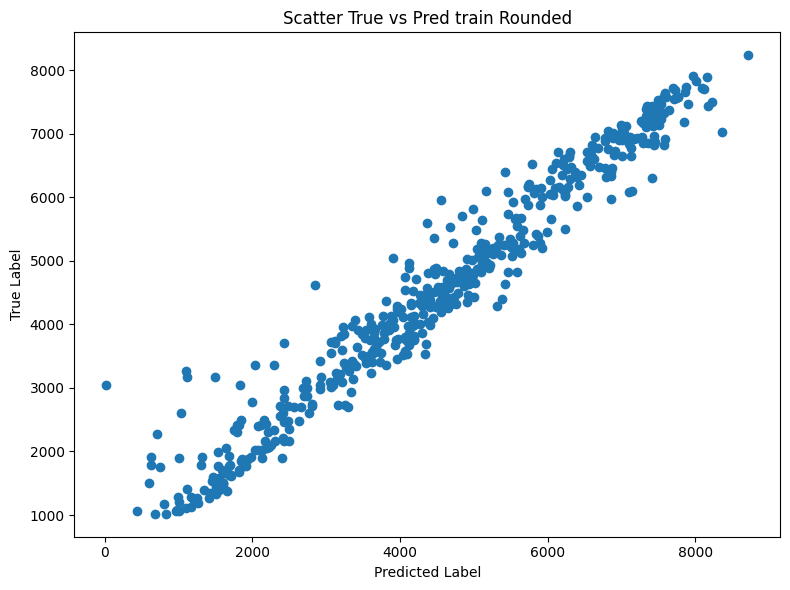

In [10]:
plot_scatter(y_train, y_train_pred, " Rounded")


## 2. Implementing AdaBoost Classifier




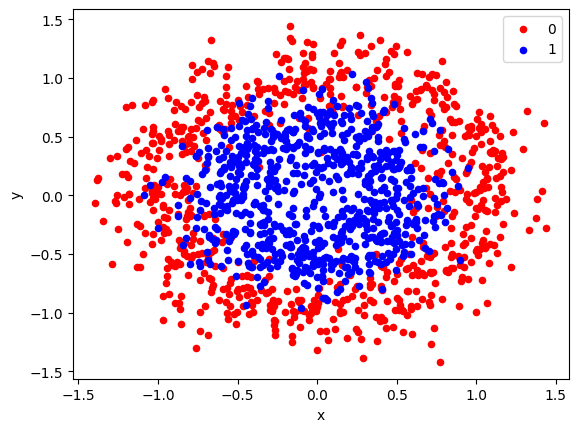

In [11]:
# load data

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [12]:
# Split the sample set into train and test sets
import numpy as np
from sklearn.model_selection import train_test_split

y = np.where(y==0, -1, 1) # our classifier needs 1 and -1 values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [13]:
from typing import Optional, Tuple, List, Any

import numpy as np
import numpy.typing as npt
from sklearn.svm import LinearSVC
from sklearn.base import clone, BaseEstimator


MAX_SEED_VALUE: int = 2**31 - 1


class AdaBoost:
    """AdaBoost ensemble classifier implementation using weighted bootstrapping.

    This AdaBoost flavor trains weak learners on data subsets sampled
    using weighted bootstrapping at each iteration.

    Parameters
    ----------
    base_estimator : BaseEstimator, optional
        The weak learner to use in the ensemble.
        Defaults to LinearSVC if None.
    n_estimators : int, default=50
        Number of boosting iterations to perform.
    n_samples : int, default=20
        Number of samples to use in each boosting iteration.

    Attributes
    ----------
    estimators_ : list
        List of fitted weak learners.
    estimator_weights_ : ndarray of shape (n_estimators,)
        Weights for each estimator in the ensemble.
    errors_ : ndarray of shape (n_estimators,)
        Error rate for each iteration.
    sample_weights_ : ndarray of shape (n_estimators, n_samples)
        History of sample weights at each iteration.
    flip_predictions_: ndarray of shape (n_samples,)
        Boolean array indicating which predictions to flip
    """

    def __init__(
            self,
            base_estimator: Optional[BaseEstimator] = None,
            n_estimators: int = 50,
            n_samples: int = 20,
            random_state: Optional[int] = None,
            ) -> None:

        self.estimators_: Optional[List[BaseEstimator]] = None
        self.estimator_weights_: Optional[npt.NDArray] = None
        self.errors_: Optional[npt.NDArray] = None
        self.sample_weights_: Optional[npt.NDArray] = None
        self.flip_predictions_: Optional[npt.NDArray]= None
        self.n_samples = n_samples
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)
        self.base_estimator = base_estimator if base_estimator is not None else LinearSVC(random_state=random_state)


    def _initialize_containers(self, n_samples: int) -> None:
        """Initialize storage containers for boosting iterations."""
        self.estimators_ = []
        self.sample_weights_ = np.zeros(shape=(self.n_estimators, n_samples))
        self.estimator_weights_ = np.zeros(shape=self.n_estimators)
        self.errors_ = np.zeros(shape=self.n_estimators)
        self.flip_predictions_ = np.zeros(self.n_estimators, dtype=bool)

    def _initialize_weights(self, n_samples: int) -> npt.NDArray:
        """Initialize sample weights uniformly."""
        return np.ones(shape=n_samples) / n_samples

    def _record_iteration(
            self,
            iteration: int,
            estimator: BaseEstimator,
            sample_weights: npt.NDArray,
            estimator_weight: float,
            error: float,
            flip_prediction: bool
            ) -> None:
        """Record the results of a boosting iteration."""
        self.estimators_.append(estimator)
        self.sample_weights_[iteration] = sample_weights
        self.estimator_weights_[iteration] = estimator_weight
        self.errors_[iteration] = error
        self.flip_predictions_[iteration] = flip_prediction

    def fit(self, X: npt.NDArray, y: npt.NDArray) -> 'AdaBoost':
        """Fit the AdaBoost ensemble classifier.

        Parameters
        ----------
        X : np.ndarray of shape (n_samples, n_features)
            Training data.
        y : np.ndarray of shape (n_samples,)
            Target values (-1, 1).

        Returns
        -------
        self : AdaBoost
            Fitted estimator.
        """
        # Check y contains valid binary labels
        if not np.all(np.isin(y, [-1, 1])):
            raise ValueError("y must contain only -1 and 1")

        n = X.shape[0]

        # Initialize storage containers
        self._initialize_containers(n)

        # Initialize algorithm weights
        sample_weights = self._initialize_weights(n)

        for t in range(self.n_estimators):
            # Get bootstrapped sample based on current weights
            X_subset, y_subset = self.weighted_bootstraping(X, y, sample_weights)

            # Train weak learner on bootstrapped sample
            estimator = clone(self.base_estimator)
            if hasattr(estimator, 'random_state'):
                estimator.random_state = self.rng.randint(MAX_SEED_VALUE)
            estimator.fit(X_subset, y_subset)

            # Get predictions on full dataset for weight updates
            estimator_pred = estimator.predict(X)

            # Calculate weighted error and estimator confidence
            error = self.calculate_error(sample_weights, y, estimator_pred)

            # Flip predictions if error is greater than 0.5
            if flip_prediction := (error > 0.5):
                estimator_pred = -estimator_pred
                error = 1 - error

            confidence = self.calculate_confidence(error)

            # Record current state
            self._record_iteration(t, estimator, sample_weights, confidence, error, flip_prediction)

            # Update weights for next iteration
            sample_weights = self.update_weights(sample_weights, y, estimator_pred, confidence)

        return self

    def weighted_bootstraping(
            self, X: npt.NDArray, y: npt.NDArray, weights: npt.NDArray
            ) -> Tuple[npt.NDArray, npt.NDArray]:
        """Perform weighted bootstrapping to create training subset."""
        indices = self.rng.choice(X.shape[0], self.n_samples, replace=True, p=weights)
        return X[indices], y[indices]

    @staticmethod
    def calculate_error(
            weights: npt.NDArray, y_true: npt.NDArray, y_pred: npt.NDArray
            ) -> float:
        """Calculate weighted error rate."""
        if np.any(weights < 0):
            raise ValueError("weights must be non-negative")
        if not np.isclose(weights.sum(), 1.0):
            raise ValueError("weights must sum to 1")
        return weights[(y_true != y_pred)].sum()

    @staticmethod
    def calculate_confidence(error: float) -> float:
        """Calculate weight for weak learner based on its error."""
        return 0.5 * np.log((1 - error) / error)

    @staticmethod
    def update_weights(
            weights: npt.NDArray, y_true: npt.NDArray, y_pred: npt.NDArray, confidence: float
            ) -> npt.NDArray:
        """Update sample weights based on misclassifications."""
        # Increase weights of misclassified samples, decrease weights of correct ones
        weights *= np.exp(-confidence * y_true * y_pred)
        # Normalize to maintain probability distribution
        weights /= weights.sum()
        return weights

    def predict(self, X: npt.NDArray, n_estimators: Optional[int] = None) -> npt.NDArray:
        """Make predictions using the fitted ensemble.

        Parameters
        ----------
        X : npt.NDArray
            Samples to predict
        n_estimators : int, optional
            Number of estimators to use for prediction.
            If None, uses all fitted estimators.
        """
        if self.estimators_ is None:
            raise ValueError("Call fit before predict")

        # Use all estimators if n_estimators not specified
        n = n_estimators if n_estimators is not None else len(self.estimators_)

        # Validate n_estimators
        if n > len(self.estimators_):
            raise ValueError(f"n_estimators ({n}) cannot be larger than number of fitted estimators ({len(self.estimators_)})")

        # Get predictions and flip where needed
        predictions = np.array([
            est.predict(X) * (-1 if flip else 1)
            for est, flip in zip(self.estimators_[:n], self.flip_predictions_[:n])
        ])

        return np.sign(np.dot(self.estimator_weights_[:n], predictions))

Colored surface is the decision plane
Points are the train data, colored by classes, size proportional to last iteration sample weights


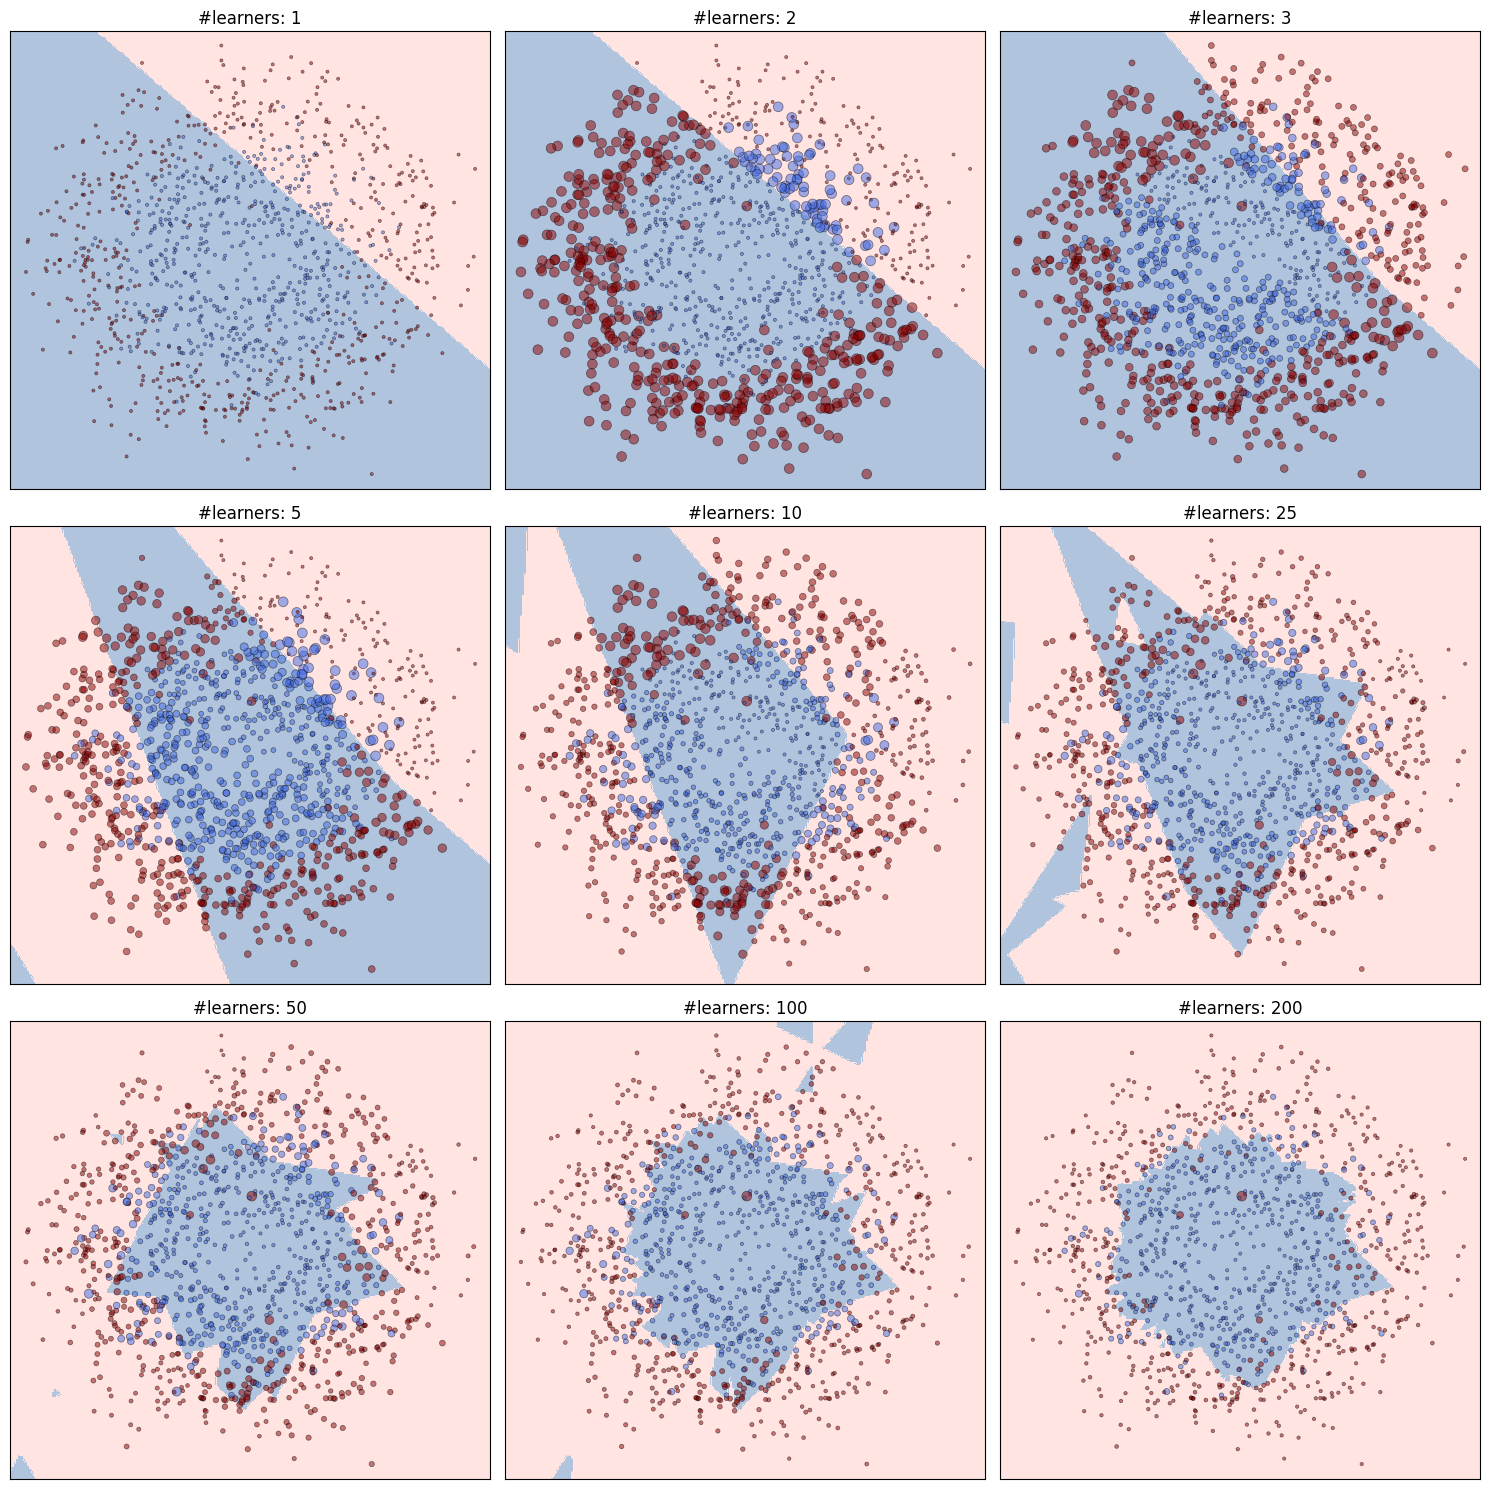

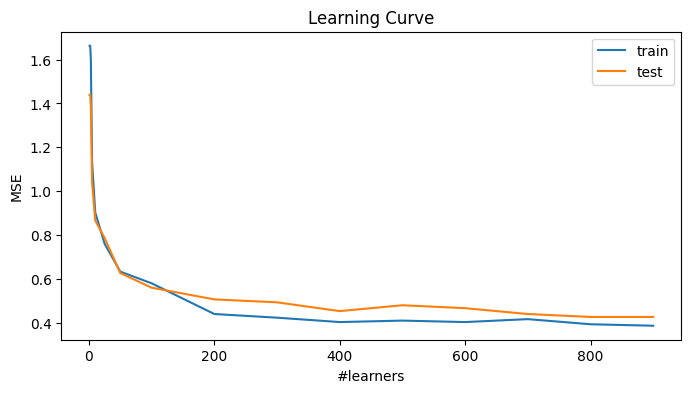

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier

# Define both ranges of weak learners
small_n = [1, 2, 3, 5, 10, 25, 50]
large_n = np.arange(100, 901, 100)  # [100, 200, ..., 800]
all_n = sorted(list(set(small_n + list(large_n))))

# Train single model, with max # of learners
model = AdaBoost(n_estimators=max(all_n), random_state=123)
model.fit(X_train, y_train)

# Collect
mses_train, mses_test = zip(*[(
    mean_squared_error(y_train, model.predict(X_train, n_estimators=n)),
    mean_squared_error(y_test, model.predict(X_test, n_estimators=n))
    ) for n in all_n])

# 1. Plot decision boundaries for small n
fig, axs = plt.subplots(3, 3, figsize=(15, 15), facecolor='w', edgecolor='k')
plot_step = 0.01

print("Colored surface is the decision plane")
print("Points are the train data, colored by classes, size proportional to last iteration sample weights")

margin = 0.1
mesh_x_min, mesh_x_max = X_train[:, 0].min() - margin, X_train[:, 0].max() + margin
mesh_y_min, mesh_y_max = X_train[:, 1].min() - margin, X_train[:, 1].max() + margin
mesh_x, mesh_y = np.meshgrid(
    np.arange(mesh_x_min, mesh_x_max, plot_step),
    np.arange(mesh_y_min, mesh_y_max, plot_step)
    )

for ax, n in zip(axs.ravel(), all_n[:9]):

    Z = model.predict(np.c_[mesh_x.ravel(), mesh_y.ravel()], n_estimators=n)
    ax.contourf(mesh_x, mesh_y, Z.reshape(mesh_x.shape), colors=('mistyrose', 'lightsteelblue'))

    weights = model.sample_weights_[n-1,:]

    # Min-max scale weights for better visualization (optional)
    # This helps prevent extremely small points
    min_size = 5  # Minimum point size
    max_size = 50  # Maximum point size
    if (w_max := weights.max()) > (w_min := weights.min()):  # Avoid division by zero
        scaled_weights = min_size + (weights - w_min) * (max_size - min_size) / (w_max - w_min)
    else:
        scaled_weights = np.ones_like(weights) * min_size

    colors = np.array(['darkred', 'royalblue'])[(y_train == 1).astype(int)]

    # Single scatter call
    scatter = ax.scatter(
        X_train[:, 0], X_train[:, 1],
        c=colors,
        s=scaled_weights, # Size based on weights
        alpha=0.5,
        edgecolors='k',
        linewidth=0.5
    )

    # Add title showing the number of estimators
    ax.set_title(f'#learners: {n}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# 2. Plot MSE curves
plt.figure(figsize=(8, 4))
plt.plot(all_n, mses_train, label="train")
plt.plot(all_n, mses_test, label="test")
plt.ylabel('MSE')
plt.xlabel('#learners')
plt.title('Learning Curve')
plt.legend()


## Conclusion

This project successfully implemented and evaluated two fundamental ensemble learning algorithms: **Random Forest** (bagging) and **AdaBoost** (boosting), demonstrating their effectiveness on different machine learning tasks.

### Key Findings

#### Random Forest Regressor
- **Performance**: Achieved strong performance on the Bike Sharing dataset with a test R² score of 0.889 (without rounding) and 0.884 (with rounding)
- **Optimal Parameters**: Through grid search, the best configuration was found to be:
  - `n_trees`: 200
  - `sample_size`: 300
  - `min_leaf`: 1
- **Out-of-Bag (OOB) Error**: Successfully implemented OOB error estimation, which provides an efficient way to evaluate model performance without requiring a separate validation set
- **Bootstrap Aggregation**: Demonstrated how combining multiple decision trees trained on bootstrap samples reduces variance and improves generalization

#### AdaBoost Classifier
- **Implementation**: Developed a robust AdaBoost implementation with key features:
  - Weighted bootstrap sampling to focus on difficult examples
  - Prediction flipping mechanism for weak learners with error > 0.5
  - Proper weight updates based on misclassification errors
  - Flexible prediction using subsets of estimators
- **Learning Dynamics**: Visualized how the algorithm adapts sample weights over iterations, with difficult examples receiving increasing attention
- **Decision Boundaries**: Observed how decision boundaries become more complex and refined as more weak learners are added to the ensemble

### Technical Insights

1. **Ensemble Diversity**: Both methods leverage diversity among base learners—Random Forest through bootstrap sampling and feature subsampling, AdaBoost through weighted sampling that emphasizes misclassified examples

2. **Bias-Variance Tradeoff**: 
   - Random Forest primarily reduces variance by averaging predictions from diverse trees
   - AdaBoost reduces both bias and variance by sequentially focusing on difficult examples

3. **Overfitting Considerations**: 
   - Random Forest showed good generalization with minimal overfitting (train: 0.961, test: 0.889)
   - AdaBoost demonstrated the importance of monitoring learning curves to prevent overfitting as the number of learners increases

4. **Implementation Quality**: The AdaBoost implementation includes robust error handling, numerical stability checks, and proper handling of weak learners that perform worse than random chance

### Practical Applications

- **Random Forest**: Well-suited for regression tasks with continuous outputs, providing interpretable feature importance and robust predictions
- **AdaBoost**: Effective for classification problems, especially when dealing with complex decision boundaries and imbalanced datasets

### Future Directions

- Experiment with different base estimators (e.g., deeper trees, different algorithms)
- Implement additional ensemble methods (e.g., Gradient Boosting, XGBoost)
- Explore hyperparameter optimization techniques beyond grid search
- Investigate feature importance analysis for both methods
- Apply to additional datasets to validate generalizability

This project demonstrates a solid understanding of ensemble learning principles and their practical implementation, providing a foundation for more advanced machine learning techniques.
